In [1]:
from monkey.src.modules.utils import show_batch
from monkey.src.modules.cgan_model import Discriminator, Generator
from monkey.src.modules.data import BrainDatasetCGAN, BrainSampler

import torch
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
import os
import time

/gpfs/project/lueic105/venv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
fom_base_path = '/gpfs/project/alobe101/data/pli/fom/'
# path_data = '../data/'
fom_paths = os.listdir(fom_base_path)

# filter for brain=Vervet1818, modality=FOM
fom_paths = [fom_base_path+f for f in fom_paths if 'Vervet1818' in f]
fom_paths

['/gpfs/project/alobe101/data/pli/fom/Vervet1818_s0850_left_FOM_HSV.h5',
 '/gpfs/project/alobe101/data/pli/fom/Vervet1818_s0759_left_FOM_HSV.h5',
 '/gpfs/project/alobe101/data/pli/fom/Vervet1818_s0961_left_FOM_HSV.h5',
 '/gpfs/project/alobe101/data/pli/fom/Vervet1818_s0830_right_FOM_HSV.h5',
 '/gpfs/project/alobe101/data/pli/fom/Vervet1818_s1061_right_FOM_HSV.h5',
 '/gpfs/project/alobe101/data/pli/fom/Vervet1818_s0961_right_FOM_HSV.h5',
 '/gpfs/project/alobe101/data/pli/fom/Vervet1818_s0880_left_FOM_HSV.h5',
 '/gpfs/project/alobe101/data/pli/fom/Vervet1818_s0860_left_FOM_HSV.h5',
 '/gpfs/project/alobe101/data/pli/fom/Vervet1818_s0850_right_FOM_HSV.h5',
 '/gpfs/project/alobe101/data/pli/fom/Vervet1818_s0880_right_FOM_HSV.h5',
 '/gpfs/project/alobe101/data/pli/fom/Vervet1818_s0820_right_FOM_HSV.h5']

In [4]:
trans_base_path = '/gpfs/project/alobe101/data/pli/transmittance/'
# path_data = '../data/'
trans_paths = os.listdir(trans_base_path)

# filter for brain=Vervet1818, modality=trans
trans_paths = [trans_base_path+f for f in trans_paths if 'Vervet1818' in f]
trans_paths

['/gpfs/project/alobe101/data/pli/transmittance/Vervet1818_s0850_right_NTransmittance.h5',
 '/gpfs/project/alobe101/data/pli/transmittance/Vervet1818_s0830_right_NTransmittance.h5',
 '/gpfs/project/alobe101/data/pli/transmittance/Vervet1818_s0820_right_NTransmittance.h5',
 '/gpfs/project/alobe101/data/pli/transmittance/Vervet1818_s0759_left_NTransmittance.h5',
 '/gpfs/project/alobe101/data/pli/transmittance/Vervet1818_s0880_right_NTransmittance.h5',
 '/gpfs/project/alobe101/data/pli/transmittance/Vervet1818_s0850_left_NTransmittance.h5',
 '/gpfs/project/alobe101/data/pli/transmittance/Vervet1818_s1061_right_NTransmittance.h5',
 '/gpfs/project/alobe101/data/pli/transmittance/Vervet1818_s0880_left_NTransmittance.h5',
 '/gpfs/project/alobe101/data/pli/transmittance/Vervet1818_s0860_left_NTransmittance.h5',
 '/gpfs/project/alobe101/data/pli/transmittance/Vervet1818_s0961_left_NTransmittance.h5',
 '/gpfs/project/alobe101/data/pli/transmittance/Vervet1818_s0961_right_NTransmittance.h5']

In [5]:
def discriminator_loss(real_scores, fake_scores):
    shape = real_scores.size()
    y_true = torch.ones(shape).to(device)
    y_fake = torch.zeros(shape).to(device)
    return F.binary_cross_entropy_with_logits(real_scores, y_true) + F.binary_cross_entropy_with_logits(fake_scores, y_fake)

def generator_loss(fake_scores, lamb=0.1):
    y_fake = torch.ones(fake_scores.size()).to(device)
    return F.binary_cross_entropy_with_logits(fake_scores, y_fake) + lamb*torch.abs(y_fake - fake_scores).mean()

In [6]:
def train(G_CGAN, D_CGAN, optimizer_D, optimizer_G,
          discriminator_loss, generator_loss,
          batch_size=64, noise_dim=128, epochs=10, lamb=0.1, save_model='../models/', show_every=50):
    batch_cnt = 0
    start = time.time()

    G_CGAN.train()
    D_CGAN.train()

    # fixed_noise = torch.randn(64, noise_dim, 2, 2).to(device)  # format NCHW
    _, ref_trans_img = next(iter(train_loader))
    loss_hist = {'G': [], 'D': []}

    for epoch in range(epochs):
        for real_fom_img, trans_img in train_loader:
            if len(real_fom_img) != batch_size:
                continue
            for k in range(1):
                fake_fom_img = G_CGAN(trans_img)
                real_fom_img = real_fom_img.to(device)
                trans_img = trans_img.to(device)

                ### train D
                optimizer_D.zero_grad()
                fake_scores = D_CGAN(torch.cat([fake_fom_img, trans_img], 1))
                real_scores = D_CGAN(torch.cat([real_fom_img, trans_img], 1)).to(device)
                loss_D = discriminator_loss(real_scores, fake_scores)
                loss_D.backward()
                optimizer_D.step()

            ### train G
            optimizer_G.zero_grad()
            fake_fom_img = G_CGAN(trans_img)
            fake_scores = D_CGAN(torch.cat([fake_fom_img, trans_img], 1))
            loss_G = generator_loss(fake_scores, lamb)
            loss_G.backward()
            optimizer_G.step()

            # logging
            loss_hist['D'].append(loss_D.item())
            loss_hist['G'].append(loss_G.item())

            if batch_cnt % show_every == 0:
                print(
                    f'batch: {batch_cnt}, loss(D) = {loss_D.item():.4f}, loss(G) = {loss_G.item():.4f}')
                show_batch(G_CGAN(ref_trans_img).detach().cpu()[:16])
            batch_cnt += 1

        print(f'epoch {epoch+1}, time elapsed: {(time.time()-start)/60:.1f} min')

    show_batch(G_CGAN(ref_trans_img).detach().cpu(),
               save=f'monkey/models/CGAN_{epochs}_epochs.png')

    torch.save(D_CGAN.state_dict(),
               save_model+f'D_CGAN_{epochs}epochs.pt')
    torch.save(G_CGAN.state_dict(),
               save_model+f'G_CGAN_{epochs}epochs.pt')
    
    return loss_hist

In [7]:
batch_size = 128
noise_dim = 128
tile_size = 64
features = 64

data = BrainDatasetCGAN(fom_paths, trans_paths, device=device)
sampler = BrainSampler(paths=fom_paths,
                       tile_size=tile_size,
                       epoch_length=10*batch_size,
                       cgan=True)

train_loader = DataLoader(dataset=data, batch_size=batch_size, sampler=sampler)

#params G: 1.56M
#params D: 1.71M

batch: 0, loss(D) = 1.4527, loss(G) = 0.9685


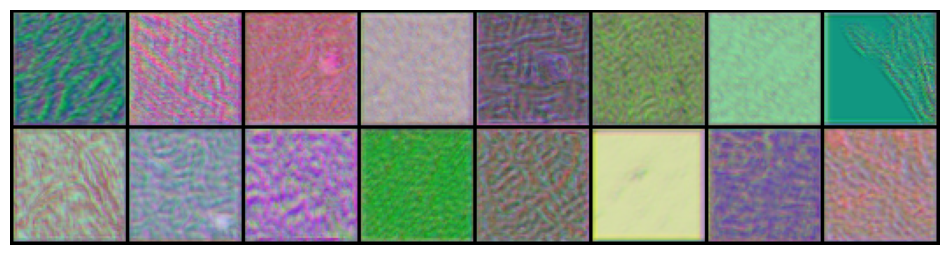

epoch 1, time elapsed: 1.9 min
epoch 2, time elapsed: 3.0 min
epoch 3, time elapsed: 4.1 min
epoch 4, time elapsed: 5.3 min
epoch 5, time elapsed: 6.3 min
epoch 6, time elapsed: 7.4 min
epoch 7, time elapsed: 8.5 min
epoch 8, time elapsed: 9.5 min
epoch 9, time elapsed: 10.6 min
epoch 10, time elapsed: 11.7 min
batch: 100, loss(D) = 0.4877, loss(G) = 2.0790


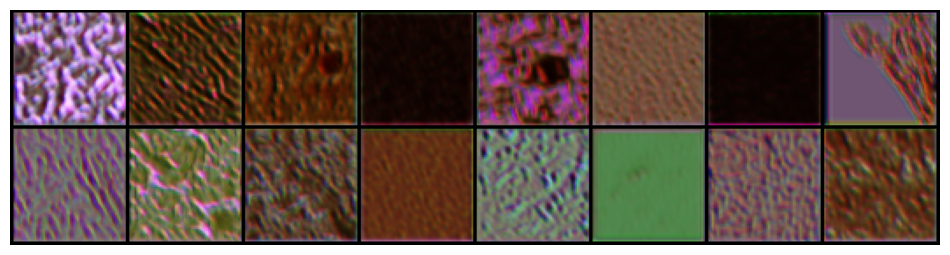

epoch 11, time elapsed: 12.8 min
epoch 12, time elapsed: 13.8 min
epoch 13, time elapsed: 14.9 min
epoch 14, time elapsed: 15.9 min
epoch 15, time elapsed: 16.9 min
epoch 16, time elapsed: 18.0 min
epoch 17, time elapsed: 19.0 min
epoch 18, time elapsed: 20.1 min
epoch 19, time elapsed: 21.1 min
epoch 20, time elapsed: 22.2 min
batch: 200, loss(D) = 0.4421, loss(G) = 2.4926


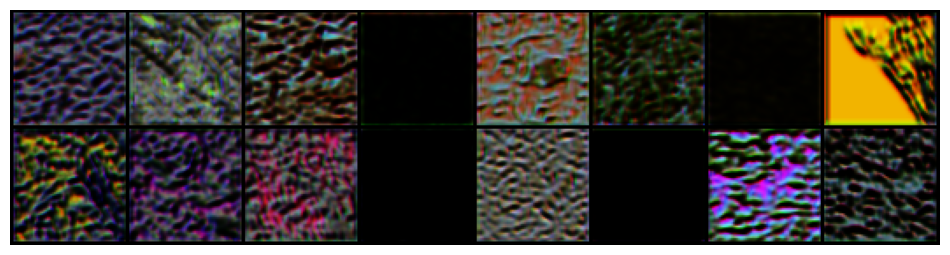

epoch 21, time elapsed: 23.2 min
epoch 22, time elapsed: 27.6 min
epoch 23, time elapsed: 31.7 min
epoch 24, time elapsed: 34.4 min
epoch 25, time elapsed: 35.6 min
epoch 26, time elapsed: 36.6 min
epoch 27, time elapsed: 37.7 min
epoch 28, time elapsed: 38.8 min
epoch 29, time elapsed: 39.8 min
epoch 30, time elapsed: 40.8 min
batch: 300, loss(D) = 0.0562, loss(G) = 5.7856


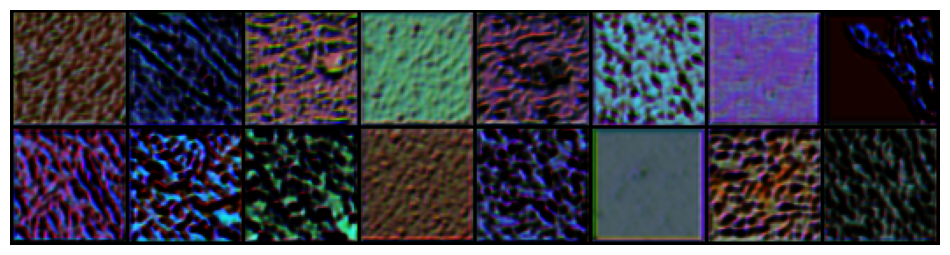

epoch 31, time elapsed: 41.9 min
epoch 32, time elapsed: 42.9 min
epoch 33, time elapsed: 44.0 min
epoch 34, time elapsed: 45.0 min
epoch 35, time elapsed: 46.0 min
epoch 36, time elapsed: 47.1 min
epoch 37, time elapsed: 48.1 min
epoch 38, time elapsed: 49.2 min
epoch 39, time elapsed: 50.3 min
epoch 40, time elapsed: 51.3 min
batch: 400, loss(D) = 0.4632, loss(G) = 1.8315


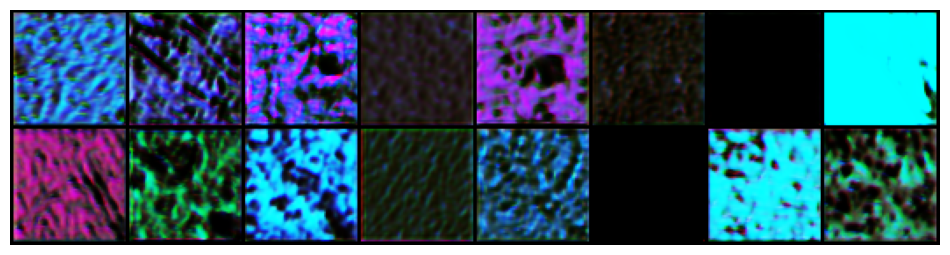

epoch 41, time elapsed: 52.3 min
epoch 42, time elapsed: 53.4 min
epoch 43, time elapsed: 54.4 min
epoch 44, time elapsed: 55.5 min
epoch 45, time elapsed: 56.5 min
epoch 46, time elapsed: 57.5 min
epoch 47, time elapsed: 58.5 min
epoch 48, time elapsed: 59.6 min
epoch 49, time elapsed: 60.6 min
epoch 50, time elapsed: 61.6 min


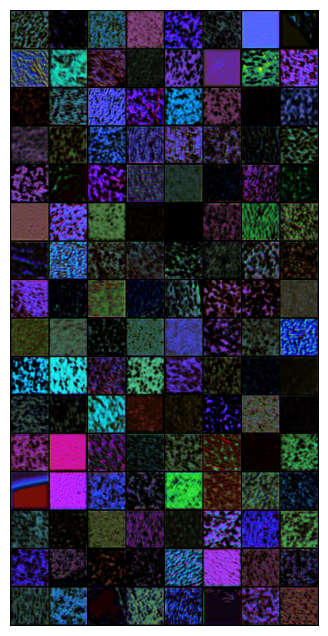

In [8]:
lr = 2e-4
n_epochs = 50

G_CGAN = Generator(latent_dim=1,
              features=features).to(device)
D_CGAN = Discriminator(features=features).to(device)

optimizer_D = torch.optim.Adam(D_CGAN.parameters(), lr=lr, betas=(0.5, 0.999))
# optimizer_D = torch.optim.RMSprop(
#     D_CGAN.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0)
optimizer_G = torch.optim.Adam(G_CGAN.parameters(), lr=lr, betas=(0.5, 0.999))

print(f'#params G: {sum(p.numel() for p in G_CGAN.parameters())/1e6:.2f}M')
print(f'#params D: {sum(p.numel() for p in D_CGAN.parameters())/1e6:.2f}M')
print()

loss_hist = train(G_CGAN, D_CGAN, optimizer_D, optimizer_G,
                  discriminator_loss, generator_loss,
                  batch_size=batch_size,
                  noise_dim=noise_dim,
                  epochs=n_epochs,
                  save_model='monkey/models/',
                  show_every=10*10)


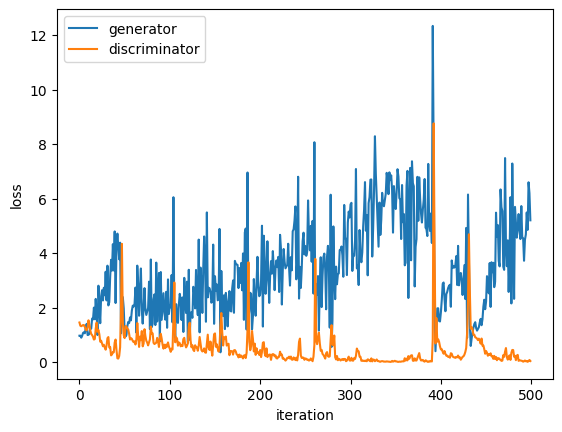

In [9]:
plt.plot(range(n_epochs*10), loss_hist['G'], label='generator')
plt.plot(range(n_epochs*10), loss_hist['D'], label='discriminator')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend();